<a href="https://colab.research.google.com/github/d-portugal/chest_x_ray/blob/main/chest_xray_APA_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import zipfile          
from zipfile import ZipFile
import splitfolders
import shutil
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import pandas as pd

# Manipulação dos dados

Importar dados

In [3]:
#Download do arquivo zip pelo google drive
!gdown 14aHeQoLFL9zu-VEKmZTTUFWIfNCfRkQp

#Diretório do zip
chest_xray = "/content/chest_xray.zip"

#Diretório para o arquivo extraido
target_dir = "/content/sample_data/dataset"

#Extração
zfile = zipfile.ZipFile(chest_xray)
zfile.extractall(target_dir)

Downloading...
From: https://drive.google.com/uc?id=14aHeQoLFL9zu-VEKmZTTUFWIfNCfRkQp
To: /content/chest_xray.zip
100% 1.15G/1.15G [00:17<00:00, 66.5MB/s]


Train Test Split

In [4]:
#Train test split, 20% dos dados serão usados para testar o modelo
treinamento_path = '/content/sample_data/dataset/chest_xray/treinamento'
splitfolders.ratio(treinamento_path, output="/content/sample_data/dataset/chest_xray", move = True,  seed=1, ratio=(.8, 0.2)) 

#Remover o folder que ficou vazio depois da divisão entre treino e teste
shutil.rmtree('/content/sample_data/dataset/chest_xray/treinamento')

#Renomear os folders
os.rename('/content/sample_data/dataset/chest_xray/validacao','/content/sample_data/dataset/chest_xray/valid')
os.rename('/content/sample_data/dataset/chest_xray/val','/content/sample_data/dataset/chest_xray/test')

Copying files: 5065 files [00:00, 18516.28 files/s]


# Definições basicas

In [5]:
#Caminhos das pastas de treino, teste e validação

train_path = '/content/sample_data/dataset/chest_xray/train'
test_path = '/content/sample_data/dataset/chest_xray/test'
valid_path = '/content/sample_data/dataset/chest_xray/valid'

#Tamanho das imagens

img_height = 128
img_width = 128

#Quantidade de imagens que será utilizada a cada iteração

batch_size = 64 

#Quantidade de classes
num_classes = 3

# Data Augmentation e carregamento dos arquivos

In [6]:
# Criar gerador de imagens para fazer Data Augmentation no arquivo de treino
train_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Gerador para os arquivos de teste e validação
test_valid_gen = ImageDataGenerator(rescale = 1./255)

Carregar dataset de imagens

In [7]:
ds_train = train_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      class_mode='categorical',
      batch_size=batch_size,
      color_mode='grayscale'
      )

ds_test = test_valid_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      shuffle=False, 
      class_mode='categorical',
      batch_size=batch_size,
      color_mode='grayscale'
      )

ds_valid = test_valid_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      class_mode='categorical', 
      batch_size=batch_size,
      color_mode='grayscale'
      )

Found 4051 images belonging to 3 classes.
Found 1014 images belonging to 3 classes.
Found 166 images belonging to 3 classes.


---

Visualização das imagens

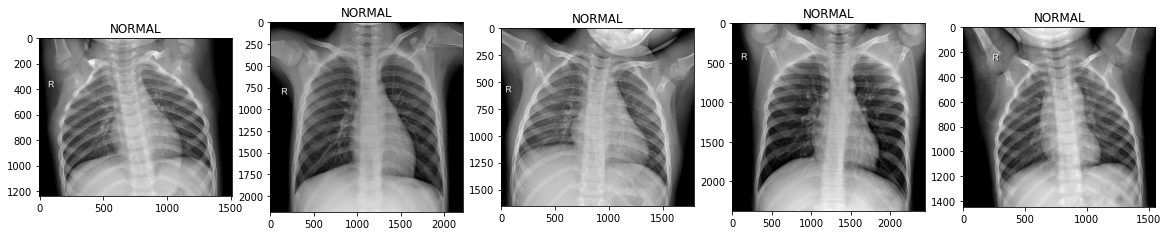

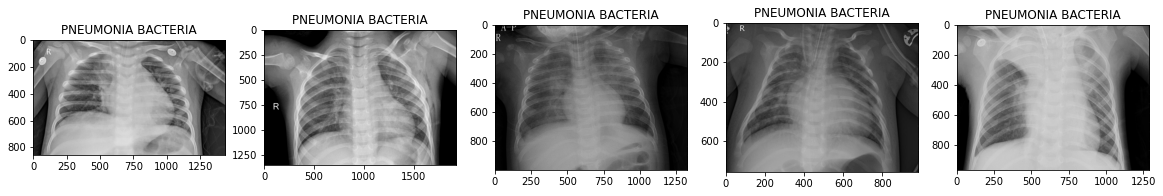

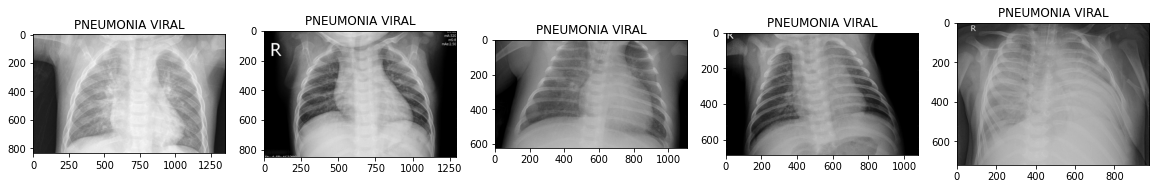

In [8]:
directory = os.listdir(train_path)
for each in directory:
    plt.figure(figsize = (20, 20))
    currentFolder = train_path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = currentFolder + "/" + file
        img = mpimg.imread(fullpath)
        plt.subplot(2, 5, i+1)
        plt.title(each)
        plt.imshow(img, cmap='gray')

# Modelagem

CNN

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1), padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1), padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1), padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1), padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1), padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'softmax', units = 3))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Visualização da arquitetura do modelo

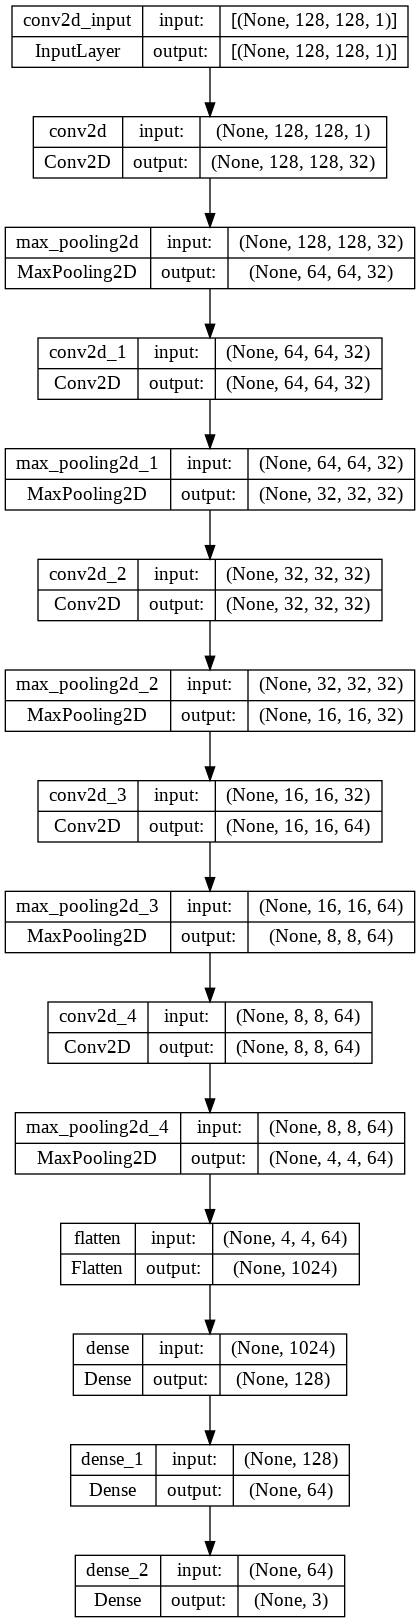

In [10]:
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Treinamento

In [11]:
# Criação de um callback para parar o treinamento caso validation loss não
# diminua em até 5 épocas

early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience = 2,
                                            verbose=1,factor=0.3,
                                            min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [12]:
# Definição de pesos para cada classe para que assim o modelo consiga aprender
# com cada uma delas igualmente

weights = compute_class_weight('balanced',
                               classes = np.unique(ds_train.classes),
                               y = ds_train.classes)

cw = dict(zip( np.unique(ds_train.classes), weights))

print(cw)

{0: 1.3343214756258235, 1: 0.6782186505943412, 2: 1.2884860050890585}


In [13]:
# Treinamento

history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 50,
    verbose = 1,
    class_weight=cw,
    callbacks=callbacks_list
)

Epoch 1/50
64/64 [==============================] - 49s 621ms/step - loss: 1.0618 - accuracy: 0.3552 - val_loss: 0.8516 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 39s 607ms/step - loss: 0.7124 - accuracy: 0.6586 - val_loss: 0.5902 - val_accuracy: 0.7349 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 39s 605ms/step - loss: 0.6223 - accuracy: 0.7082 - val_loss: 0.6001 - val_accuracy: 0.7108 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7137
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
64/64 [==============================] - 38s 591ms/step - loss: 0.5981 - accuracy: 0.7137 - val_loss: 0.6146 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 39s 604ms/step - loss: 0.5517 - accuracy: 0.7485 - val_loss: 0.5229 - val_accuracy: 0.7651 - lr: 3.0000e-04
Epoch 6/50
64/64 [==============================] - 39s 6

Salvar modelos

In [14]:
model.save('model.h5')

Acuracidade do modelo treinado

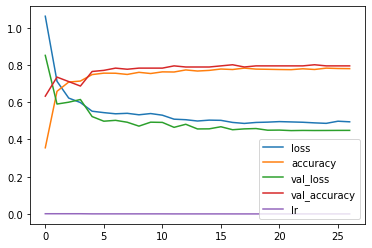

In [17]:
pd.DataFrame(model.history.history).plot()

# Predição

In [18]:
valid_accuracy = model.evaluate(ds_valid)
print('The testing accuracy is :',valid_accuracy[1]*100, '%')

3/3 [==============================] - 2s 494ms/step - loss: 0.4487 - accuracy: 0.7952
The testing accuracy is : 79.51807379722595 %


In [19]:
predict = model.predict(ds_valid,verbose=1)

3/3 [==============================] - 2s 509ms/step


# Acuracidade

In [20]:
CLASSES = ['NORMAL','PNEUMONIA BACTERIA','PNEUMONIA VIRAL']
print(classification_report(y_true = ds_valid.classes,
                            y_pred = np.argmax(predict, axis = 1),
                            target_names = CLASSES))

                    precision    recall  f1-score   support

            NORMAL       0.57      0.62      0.60        82
PNEUMONIA BACTERIA       0.28      0.31      0.29        49
   PNEUMONIA VIRAL       0.29      0.20      0.24        35

          accuracy                           0.44       166
         macro avg       0.38      0.38      0.38       166
      weighted avg       0.43      0.44      0.43       166



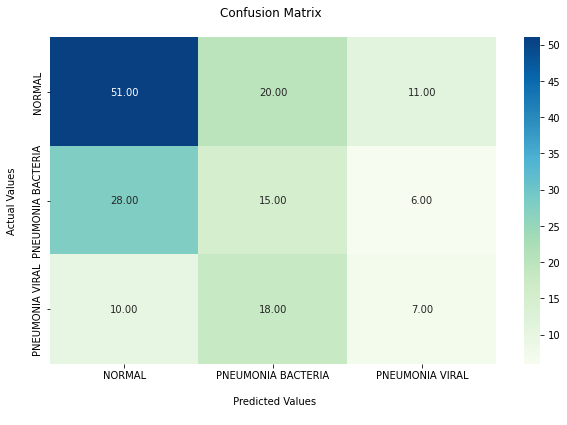

In [23]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(ds_valid.classes,np.argmax(predict, axis = 1)), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(CLASSES)
fx.yaxis.set_ticklabels(CLASSES)
plt.show()